In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sql_connection import sql_connect, write_sql_conn_create
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.decomposition import PCA
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings("ignore", message="pandas only supports SQLAlchemy connectable")

In [2]:
query = "select * from cleaned_application_ml"
app_data = sql_connect(query)
app_data.head()

Connection to SQL Server established successfully.
Connection closed.


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AVERAGE_EXTERNAL_RATING,TOT_PREV_APP,PREV_APPROVED_CNT,PREV_CANCELLED_CNT,PREV_REFUSED_CNT,PREV_UNUSED_CNT,ISMISSING_BUREAU_INFO
0,100002,1,Cash loans,M,0,1,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120.0,-1,1,1,0,1,1,0,Laborers,1,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,2,2,2,2,-1134,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.1618,0,0,0,0,0,0
1,100003,0,Cash loans,F,0,0,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291.0,-1,1,1,0,1,1,0,Core staff,2,1,1,MONDAY,11,0,0,0,0,0,0,School,1,0,1,0,-828,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.4668,0,0,0,0,0,0
2,100004,0,Revolving loans,M,1,1,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531.0,26,1,1,1,1,1,0,Laborers,1,2,2,MONDAY,9,0,0,0,0,0,0,Government,0,0,0,0,-815,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.6427,0,0,0,0,0,0
3,100006,0,Cash loans,F,0,1,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437.0,-1,1,1,0,1,0,0,Laborers,2,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,2,0,2,0,-617,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.6504,0,0,0,0,0,1
4,100007,0,Cash loans,M,0,1,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458.0,-1,1,1,0,1,0,0,Core staff,1,2,2,THURSDAY,11,0,0,0,0,1,1,Religion,0,0,0,0,-1106,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.3227,1,1,0,0,0,0


In [3]:
X = app_data.drop(columns=['SK_ID_CURR', 'TARGET'])
y = app_data['TARGET']

Numeric field will need to be standardized before apply pca

In [4]:
numeric_col = [col for col in X.columns if X[col].dtype != 'object' and X[col].nunique() > 2 and col not in ['SK_ID_CURR', 'TARGET']]

### Class imbalance

Text(0.5, 0, 'Target')

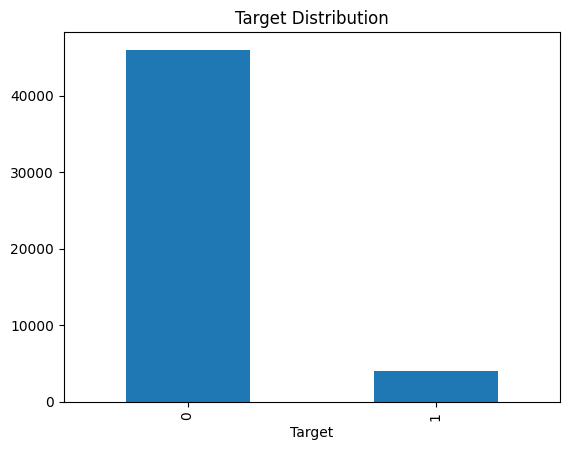

In [5]:
app_data['TARGET'].value_counts().plot(kind='bar', title='Target Distribution')
plt.xlabel('Target')    

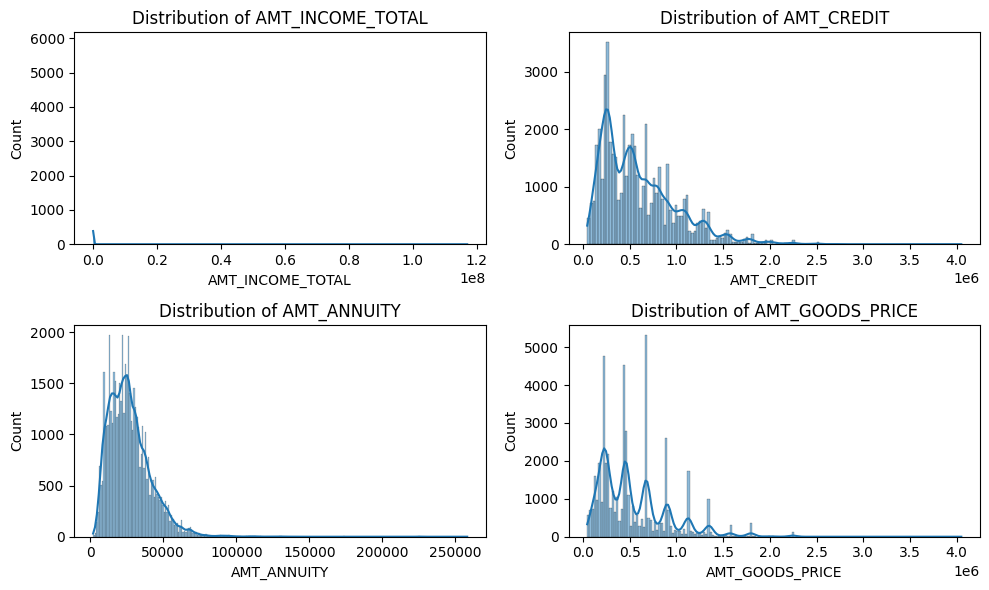

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6))
ax = ax.flatten()
for i, col in enumerate(numeric_col[1:5]):
    sns.histplot(app_data[col], kde=True, ax=ax[i])
    ax[i].set_title(f'Distribution of {col}')
plt.tight_layout()
plt.show();

### All the amount data are highly skewed

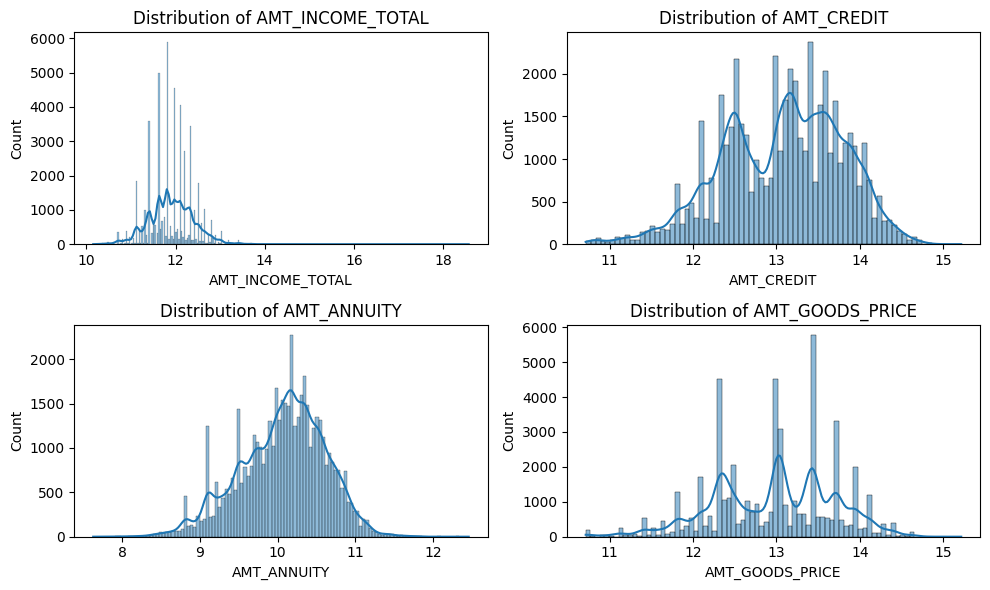

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6))
ax = ax.flatten()
for i, col in enumerate(numeric_col[1:5]):
    sns.histplot(np.log1p(app_data[col]), kde=True, ax=ax[i])
    ax[i].set_title(f'Distribution of {col} after log transformation')
plt.tight_layout()
plt.show();

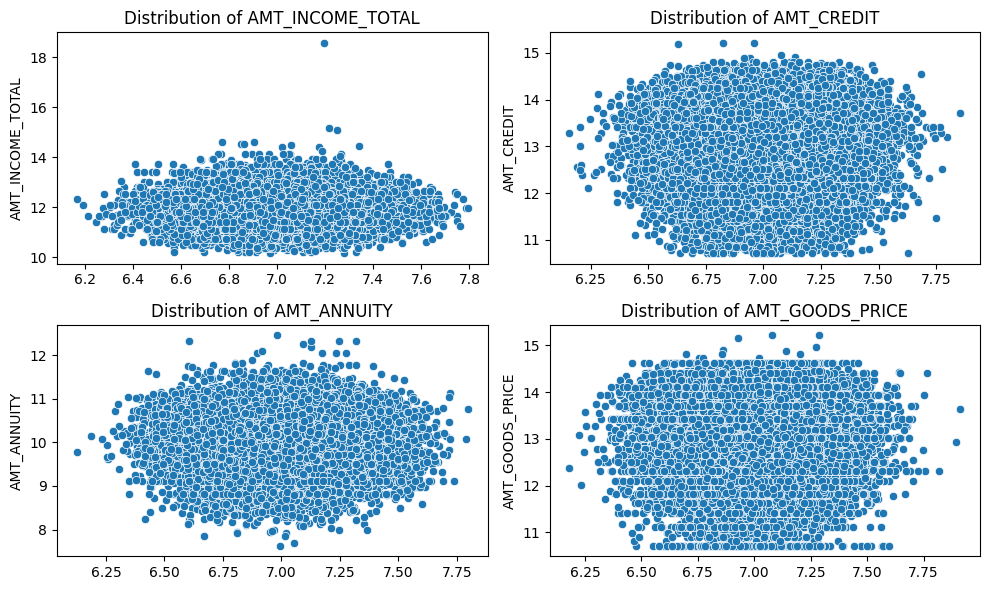

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6))
ax = ax.flatten()
for i, col in enumerate(numeric_col[1:5]):
    sns.scatterplot(x=np.random.normal(7, 0.2, size=len(app_data)), y=np.log1p(app_data[col]), ax=ax[i])
    ax[i].set_title(f'Distribution of {col}')
plt.tight_layout()
plt.show();

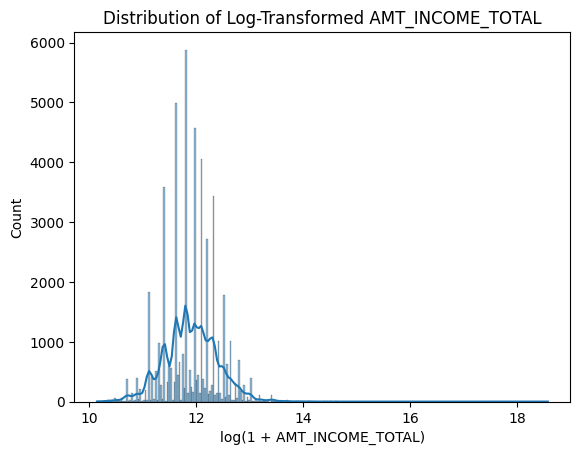

In [8]:
sns.histplot(np.log1p(app_data['AMT_INCOME_TOTAL']), kde=True)
plt.xlabel("log(1 + AMT_INCOME_TOTAL)")
plt.title("Distribution of Log-Transformed AMT_INCOME_TOTAL")
plt.show()

<Axes: ylabel='AMT_INCOME_TOTAL'>

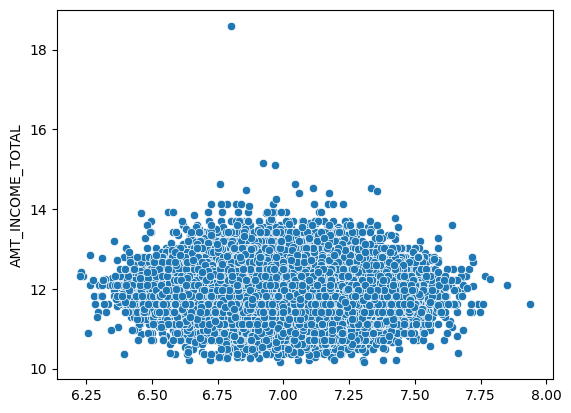

In [9]:
sns.scatterplot(x=np.random.normal(7, 0.2, size=len(app_data)), y=np.log1p(app_data['AMT_INCOME_TOTAL']))

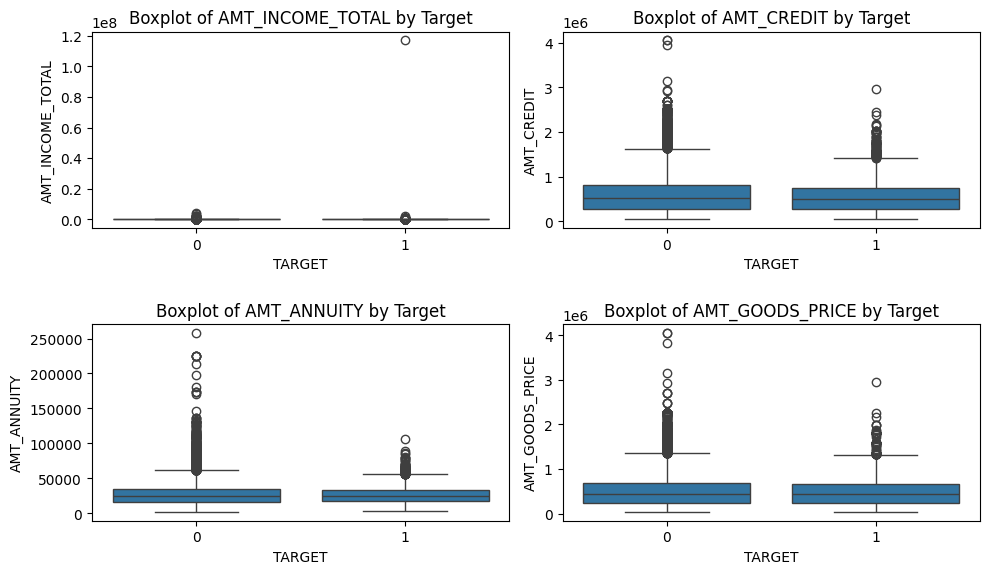

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6))
ax = ax.flatten()
for i, col in enumerate(numeric_col[1:5]):
    sns.boxplot(x = 'TARGET', y = col, ax=ax[i],data=app_data)
    ax[i].set_title(f'Boxplot of {col} by Target')
plt.tight_layout()
plt.show();

<Axes: xlabel='TARGET', ylabel='AMT_INCOME_TOTAL'>

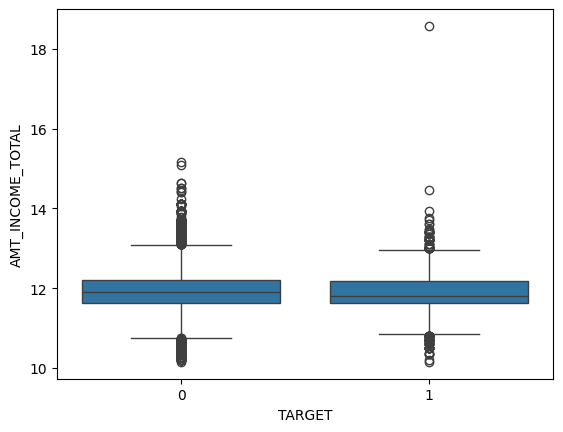

In [11]:
sns.boxplot(x = app_data['TARGET'], y = np.log1p(app_data['AMT_INCOME_TOTAL']))